In [1]:
import sentencepiece as spm

In [2]:
fname = 'data/fbwq_half_lego/train.txt'
entities = set()
f = open(fname)
for line in f:
    line = line.rstrip().split('\t')[-1]
    entities.add(line)
f.close()
len(entities)

149681

In [3]:
entities_with_no_name = set()
for e in entities:
    if e.startswith('m.') or e.startswith('g.'):
        if '.' in e[2:] or ' ' in e[2:]:
            pass
        else:
            entities_with_no_name.add(e)
len(entities_with_no_name)

14162

In [10]:
# text_file_for_spm = 'data/fbwq_half_lego/train.txt'
user_defined_symbols = list(entities_with_no_name)
# user_defined_symbols = []
text_file_for_spm = 'botchan.txt'
vocab_size = 40000

In [ ]:
import sentencepiece as spm
sp = spm.SentencePieceTrainer.train(input=text_file_for_spm,
                               model_prefix='webqsp_with_ents', 
                               vocab_size=vocab_size, 
                               user_defined_symbols=user_defined_symbols,
#                                model_type='BPE',
                               pad_id=3)

In [11]:
sp = spm.SentencePieceProcessor(model_file='webqsp_with_ents.model')

In [13]:
sp.encode("predict tail: m.05lwjxd")

[18, 16, 21, 17, 14, 4]

In [ ]:
sp['m.05lwjxd']

In [45]:
sp.id_to_piece(5)

'bar'

In [54]:
vocab_size = 30000
sp2 = spm.SentencePieceTrainer.train(input='data/codex-l/full.txt', 
                               model_prefix='codex_with_pad', vocab_size=vocab_size, 
                               pad_id=3,
                              )

In [26]:
sp2 = spm.SentencePieceProcessor(model_file='codex_with_pad.model')

In [27]:
sp2['<pad>']

3

In [57]:
# sp = spm.SentencePieceProcessor(model_file='wd5m.model')
sp = spm.SentencePieceProcessor(model_file='data/sentencepiece/metaqa_with_pad.model')
# sp = spm.SentencePieceProcessor(model_file='codex_with_pad2.model')
sp.encode('the films written by NE starred which actors')

[23, 338, 12, 18, 11, 482, 13, 2332, 134, 4, 14]

In [58]:
len(sp)

10000

In [59]:
sp.decode([[23, 338, 12, 18, 11, 482, 13, 2332, 134, 4, 14]])

['the films written by NE starred which actors']

In [51]:
from tqdm.notebook import tqdm
lines = []
fname = 'data/codex-m/train.txt'
f = open(fname, 'r')
for line in f:
    line = line.strip().split('\t')[0]
    lines.append(line)
f.close()

In [52]:
lengths = []
for line in tqdm(lines):
    x = sp.encode(line)
    lengths.append(len(x))

In [53]:
max(lengths)

34

In [41]:
sp['</s>']

2

Text(0.5, 0, 'Tokenized lengths')

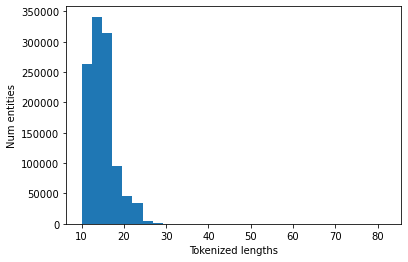

In [43]:
import matplotlib.pyplot as plt 

import numpy as np 

%matplotlib inline

# x = np.random.normal(size = 1000) 
x = lengths
plt.hist(x, bins=30) 

plt.ylabel('Num entities');
plt.xlabel('Tokenized lengths')

In [107]:
input1 = 'predict head: obama | position held |'
input2 = 'predict tail: f | f |'
out = sp.encode([input1, input2])
for x in out:
    x.append(sp['</s>'])
length = max(map(len, out))
y = np.array([xi+[sp['<pad>']]*(length-len(xi)) for xi in out])
y

array([[    5,     7,     4, 21171,     3,    88,   257,     3,     2],
       [    5,     8,     4,    68,     3,    68,     3,     2,     0]])

In [96]:
lengths = [len(x) for x in out]
lengths

[9, 8]

In [100]:
max_len = max(lengths)
attention_mask = np.zeros((len(lengths), max_len), dtype=np.long)
for i, l in enumerate(lengths):
    attention_mask[i][:l] = np.ones((l), dtype=np.long)
attention_mask

array([[1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 0]])

In [117]:
import torch
x = torch.LongTensor(y)
x

tensor([[    5,     7,     4, 21171,     3,    88,   257,     3,     2],
        [    5,     8,     4,    68,     3,    68,     3,     2,     0]])

In [119]:
sp.decode([0, 0, 0])

' ⁇  ⁇  ⁇ '

In [81]:
import numpy as np
lengths = [len(x) for x in out]
max_len = max(lengths)
# np.pad(out, (1,1))
x = np.zeros((len(out), max_len), dtype=np.long)
x[0] = out[0]
x[1][:lengths[1]] = out[1]

In [116]:
x = sp.encode('hello f')
x.append(sp['</s>'])
x = np.array(x)
x = x.tolist()
print(x)
sp.decode(x)

[8318, 68, 2]


'hello f'

In [41]:
for _ in range(5):
    x = sp.encode('predict head: obama | position held |', out_type=str, enable_sampling=True, alpha=0.5, nbest_size=-1)
    print(x)

['▁predict', '▁head', ':', '▁obama', '▁|', '▁position', '▁held', '▁|']
['▁predict', '▁head', ':', '▁obama', '▁|', '▁position', '▁held', '▁|']
['▁predict', '▁head', ':', '▁obama', '▁|', '▁position', '▁hel', 'd', '▁|']
['▁predict', '▁head', ':', '▁obama', '▁|', '▁position', '▁held', '▁|']
['▁predict', '▁head', ':', '▁ob', 'ama', '▁|', '▁position', '▁held', '▁|']


In [3]:
import os
from transformers import XLMTokenizer
from transformers import PreTrainedTokenizer
from transformers import GPT2Tokenizer

def saveBPETokenizer(tokenizer, prefix):
    # make directory for tokenizer
    path = os.path.join('data/bpe', prefix)
    if not os.path.exists(path):
        os.mkdir(path)
    # save + load data
    main_fname = 'data/bpe/{}/main.json'.format(prefix)
    tokenizer.save(main_fname)
    f = open(main_fname, 'r')
    data = json.load(f)
    f.close()
    #save data in format required by transformers.PretrainedTokenizer
    vocab_fname = 'data/bpe/{}/vocab.json'.format(prefix)
    merges_fname = 'data/bpe/{}/merges.txt'.format(prefix)
    json_object = json.dumps(data['model']['vocab'])
    with open(vocab_fname, "w") as outfile:
        outfile.write(json_object)
    f = open(merges_fname, 'w')
    for x in data['model']['merges']:
        f.write(x +'\n')
    f.close()
    print('Saved')
    
def saveWordPieceTokenizer(tokenizer, prefix):
    # make directory for tokenizer
    path = os.path.join('data/wordpiece', prefix)
    if not os.path.exists(path):
        os.mkdir(path)
    # save + load data
    main_fname = 'data/wordpiece/{}/main.json'.format(prefix)
    tokenizer.save(main_fname)
    print('Saved')



def loadBPETokenizer(prefix):
    vocab_fname = 'data/bpe/{}/vocab.json'.format(prefix)
    merges_fname = 'data/bpe/{}/merges.txt'.format(prefix)
#     tokenizer = XLMTokenizer(vocab_file=vocab_fname, merges_file=merges_fname)
    tokenizer = GPT2Tokenizer(vocab_file=vocab_fname, merges_file=merges_fname, 
                              unk_token='<unk>', 
                              bos_token='<s>', 
                              eos_token='</s>', 
                              add_prefix_space=True)
    return tokenizer

In [4]:
# saveBPETokenizer(tokenizer, 'codexm{}'.format(vocab_size))
saveWordPieceTokenizer(tokenizer, 'wikidata5m_{}'.format(vocab_size))

Saved


In [6]:
# text = train_data[0]
text = 'hello world'
tokenizer.encode_batch(["predict tail: obama | united states of america |", "How are you 😁 ?", text])

[Encoding(num_tokens=10, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing]),
 Encoding(num_tokens=5, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing]),
 Encoding(num_tokens=2, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])]

In [7]:
text = 'hello world  </s>'
tokenizer.enable_padding(pad_id=2, pad_token="<pad>")
x = tokenizer.encode_batch(["Hello, y'all!", "How are you 😁 ?", text])
x[2].tokens

['hello', 'world', '</s>', '<pad>', '<pad>', '<pad>']

In [12]:
x = tokenizer.encode('predict relation: obama | united states of america | </s>').ids
y = tokenizer.encode('fsadlk jfasdkf jsadlkfjas lkdjf').ids
out = tokenizer.decode_batch([x,y], skip_special_tokens=True)
# for x in out:
#     x = x.replace(' ##', '')
#     print(x)

In [8]:
y = tokenizer.encode('predict tail: obama | united states of america | </s>')
y.tokens

['predict',
 'tail',
 ':',
 'obama',
 '|',
 'united',
 'states',
 'of',
 'america',
 '|',
 '</s>']

In [236]:
tokenizer.encode('<pad>').ids[0]

2

In [209]:
tk = loadBPETokenizer('codexm{}'.format(vocab_size))

In [210]:
text = ' hello world'

In [270]:
tokenized = tk(text, truncation=True, max_length=128, return_tensors="pt")
# tokenized_ids = [0 if token == None else token for token in tokenized.input_ids]
# ''.join(tk.convert_ids_to_tokens(tokenized_ids))

In [59]:
t5tk.pad_token_id

0

In [277]:
import numpy as np
x = [1,2,3,4]
x = np.array(x)
np.stack([x,x])

array([[1, 2, 3, 4],
       [1, 2, 3, 4]])

In [259]:
from transformers import BatchEncoding
da = {}
da['input_ids'] = x.input_ids
da['attention_mask'] = x.attention_mask
da2 = BatchEncoding(da)
da2.input_ids

[3,
 65,
 42,
 36,
 53,
 3,
 77,
 31,
 3,
 34,
 3,
 1115,
 56,
 3,
 1587,
 3,
 617,
 3,
 60,
 3,
 193,
 3,
 111,
 3,
 60,
 3,
 554,
 3,
 777,
 107,
 122,
 211]

In [118]:
train_data = []
fname = 'data/codex-m/train.txt'
f = open(fname, 'r')
for line in f:
    train_data.append(line.strip())

In [197]:
tk.unk_token 

'<unk>'

In [20]:
import json
  
# Opening JSON file
fname = "data/tokenizer-codexm-2k.json"
f = open(fname, 'r')
  
# returns JSON object as 
# a dictionary
data = json.load(f)


In [22]:
kwargs = {
    'pretrained_vocab_files_map ': data
}


In [26]:
# tokenizer =  XLMTokenizer(vocab_file='vocab.json', merges_file='merges.txt')

Calling PreTrainedTokenizer.from_pretrained() with the path to a single file or url is deprecated


IndexError: list index out of range

In [88]:
xlmtk = XLMTokenizer.from_pretrained('xlm-mlm-en-2048')

In [89]:
xlmtk.convert_ids_to_tokens([0,1,2,3,4,5,6,7,8])

['<s>',
 '</s>',
 '<pad>',
 '<unk>',
 '<special0>',
 '<special1>',
 '<special2>',
 '<special3>',
 '<special4>']

In [90]:
xlmtk.special_tokens

AttributeError: 'XLMTokenizer' object has no attribute 'special_tokens'

In [74]:
mytk = XLMTokenizer(vocab_file='vocab.json', merges_file='merges.txt')

In [75]:
mytk.convert_ids_to_tokens([0,1,2,3,4,5])

['<unk>', '<s>', '</s>', '<pad>', '<mask>', '!']

In [33]:
tokenizer.save('data/bpe', 'codexm2k')


TypeError: Can't convert 'codexm2k' to PyBool

In [34]:
tokenizer.save

<function Tokenizer.save(self, pretty=False)>

In [39]:
f = open('merges.txt', 'w')
for x in data['model']['merges']:
    f.write(x +'\n')
f.close()

In [42]:
from transformers import XLMTokenizer

In [44]:
tk2 = XLMTokenizer(vocab_file='vocab.json', merges_file='merges.txt')

In [45]:
tk2.vocab_size

2000

In [29]:
from transformers import T5Tokenizer

In [30]:
t5tk = T5Tokenizer.from_pretrained('t5-small')

In [60]:
t5tk.convert_tokens_to_ids('<e>')

2

In [35]:
t5tk('hello <s>')

{'input_ids': [21820, 3, 2, 7, 3155, 1], 'attention_mask': [1, 1, 1, 1, 1, 1]}

In [76]:
t5tk.convert_ids_to_tokens([0,1,2,3,4,5])

['<pad>', '</s>', '<unk>', '▁', 'X', '.']